Read in libraries

In [3]:
import openpyxl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import requests

Functions that I made/found/edited to make my life easier

In [4]:

def stats_df_creator (df, grouping, column):
    '''
    Parameters
    ----------
    df : dataframe of data
    grouping : column to group by
    column : column we want stats on
    Returns df with mean, median and third quantile values for column
    '''
    stats_df = df.groupby([grouping]).agg(
        median=(column , np.median),
        mean = (column, np.mean),
        third_quantile = ( column, lambda x: np.percentile(x, q=75))       
        )
    return stats_df



In [5]:
def print_countries(index_phrase, df):
    '''
    Parameters
    ----------
    index_phrase : phrase decribing the current index that I am printing
    df : df that top 5 countries of that index are in
    prints the countries for the top 5 scaled index
    '''
    print('The 5 countries in which salary goes the farthest on the ' +str(index_phrase) + ' index are:\n')

    for idx, country_code in enumerate(df['employee_residence']):
        for key, value in country_code_dict.items():
            if country_code == value:
                print(key)
    return
    

In [19]:
def convert_currency(amount, from_currency):
    '''
    Parameters
    ----------
    amount : amount of money to be converted
    from_currency: currency to be converted from
    Returns currency is USD
    '''
    response = requests.get("https://v6.exchangerate-api.com/v6/45ab531ce52b1a50df0c239b/latest/USD")
    data = response.json()

    if 'conversion_rates' in data:
        rates = data['conversion_rates']
        if from_currency == '':
            return amount

        if from_currency in rates :
            converted_amount = amount / rates[from_currency]
            return converted_amount
        else:
            raise ValueError("Invalid currency!")
    else:
        raise ValueError("Unable to fetch exchange rates!")
    return

In [7]:
def print_cities(index_phrase, df):
    '''
    Parameters
    ----------
    index_phrase : phrase decribing the current index that I am printing
    df : df that top 5 citiess of that index are in
    prints the cities for the top 5 scaled index
    '''
    print('The 5 cities in which salary goes the farthest on the ' +str(index_phrase) + ' index are:')

    for idx, city in enumerate(df['City']):
        print(city)
    return

Read in all the data files, including the currency codes I got from https://www.exchangerate-api.com/docs/supported-currencies . 

Then remove parenthesis from the country codes df. 

In [8]:
cost_of_living_df = pd.read_csv('cost_of_living.csv')
country_codes_df = pd.read_excel('country_codes.xlsx', engine='openpyxl')
ds_salaries_df = pd.read_csv('ds_salaries.csv')
levels_fyi_salary_data_df = pd.read_csv('Levels_Fyi_Salary_Data.csv')
currency_codes = pd.read_csv('currency_codes.csv')

#removning the () from the country names
country_codes_df['Country'] = country_codes_df['Country'].str.replace('\(.*\)','')

C:\Users\hawthorner\AppData\Local\Temp\ipykernel_22188\2988162007.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  country_codes_df['Country'] = country_codes_df['Country'].str.replace('\(.*\)','')


Convert currency codes df and country codes  to dictionaries to be used later.

In [9]:
from collections import defaultdict
# Function to return a default
# values for keys that is not
# present
def def_value():
    return "Not Present"

country_code_dict = defaultdict(def_value, zip(country_codes_df['Country'], country_codes_df['Alpha-2 code']))

currency_codes_dict= defaultdict(def_value, zip(currency_codes['Country'], currency_codes['Currency Code']))

Start editing salary data:

Get just data science salaries for entry level (less then 4 years of expereince), fulltime employes from Levels_fyi_slary_data_df and ds_salaries_df

Then return columns with salary date, location, and salary

Reindex

In [10]:
data_science_levels_fyi_salary_data_df = levels_fyi_salary_data_df.loc[(levels_fyi_salary_data_df["title"] =='Data Scientist')
                              &(levels_fyi_salary_data_df["yearsofexperience"] < 4),
                              ['timestamp','totalyearlycompensation', 'location']]



data_science_ds_salaries_df = ds_salaries_df.loc[(ds_salaries_df['job_title'] == 'Data Scientist') 
                   & (ds_salaries_df['employment_type'] == 'FT') 
                   & (ds_salaries_df['experience_level'] == 'EN'), 
                   ['work_year' , 'salary_in_usd' , 'employee_residence']]

data_science_ds_salaries_df = data_science_ds_salaries_df.reset_index(drop=True)

data_science_levels_fyi_salary_data_df = data_science_levels_fyi_salary_data_df.reset_index(drop=True)

print(data_science_levels_fyi_salary_data_df.head())
print(data_science_ds_salaries_df.head())

            timestamp  totalyearlycompensation           location
0  6/17/2018 19:02:50                   200000        Seattle, WA
1  6/21/2018 10:54:35                   600000      Los Gatos, CA
2  8/15/2018 11:57:44                   120000     Washington, DC
3  8/15/2018 15:38:02                   220000        Redmond, WA
4  8/15/2018 20:38:36                   147000  San Francisco, CA
   work_year  salary_in_usd employee_residence
0       2020          51321                 FR
1       2020          39916                 FR
2       2020          62726                 DE
3       2020          49268                 DE
4       2020         105000                 US


cleaning data:
    For data_science_levels_fyi_salary_data_df
    Create work_year column
    
    Break location into city, state and country; then add country code    

In [11]:
data_science_levels_fyi_salary_data_df.dtypes

data_science_levels_fyi_salary_data_df['work_year'] = pd.to_datetime(data_science_levels_fyi_salary_data_df['timestamp'] , format='%m/%d/%Y %H:%M:%S').dt.year

data_science_levels_fyi_salary_data_df[['city','state','country']] = data_science_levels_fyi_salary_data_df["location"].str.split(', ',expand=True)

 
#####add country for those locations that only had city and state

for idx, value in enumerate (data_science_levels_fyi_salary_data_df['state']):  
    if (len(value) == 2) & (data_science_levels_fyi_salary_data_df['country'][idx] == None):
        data_science_levels_fyi_salary_data_df['country'][idx] = 'United States'
    elif data_science_levels_fyi_salary_data_df['country'][idx] == None:
        print(idx)
    
###only printed index of 161 which correlates to Israel
data_science_levels_fyi_salary_data_df['country'][161] = 'Israel' 

print(data_science_levels_fyi_salary_data_df.head())

C:\Users\hawthorner\AppData\Local\Temp\ipykernel_22188\3070310417.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_science_levels_fyi_salary_data_df['country'][idx] = 'United States'


161
            timestamp  totalyearlycompensation           location  work_year  \
0  6/17/2018 19:02:50                   200000        Seattle, WA       2018   
1  6/21/2018 10:54:35                   600000      Los Gatos, CA       2018   
2  8/15/2018 11:57:44                   120000     Washington, DC       2018   
3  8/15/2018 15:38:02                   220000        Redmond, WA       2018   
4  8/15/2018 20:38:36                   147000  San Francisco, CA       2018   

            city state        country  
0        Seattle    WA  United States  
1      Los Gatos    CA  United States  
2     Washington    DC  United States  
3        Redmond    WA  United States  
4  San Francisco    CA  United States  


C:\Users\hawthorner\AppData\Local\Temp\ipykernel_22188\3070310417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_science_levels_fyi_salary_data_df['country'][161] = 'Israel'


Add currency code for currency conversion from the currency code dictionary.

In [12]:
data_science_levels_fyi_salary_data_df['currency_code']=''
data_science_levels_fyi_salary_data_df['employee_residence']=''

for idx, value in enumerate (data_science_levels_fyi_salary_data_df['country']):
    data_science_levels_fyi_salary_data_df['currency_code'][idx] = [val for key, val in currency_codes_dict.items() if re.search(value, key)]
    data_science_levels_fyi_salary_data_df['employee_residence'][idx] = [val for key, val in country_code_dict.items() if value in key]

print(data_science_levels_fyi_salary_data_df.head())

C:\Users\hawthorner\AppData\Local\Temp\ipykernel_22188\3301572926.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_science_levels_fyi_salary_data_df['currency_code'][idx] = [val for key, val in currency_codes_dict.items() if re.search(value, key)]
C:\Users\hawthorner\AppData\Local\Temp\ipykernel_22188\3301572926.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_science_levels_fyi_salary_data_df['employee_residence'][idx] = [val for key, val in country_code_dict.items() if value in key]


            timestamp  totalyearlycompensation           location  work_year  \
0  6/17/2018 19:02:50                   200000        Seattle, WA       2018   
1  6/21/2018 10:54:35                   600000      Los Gatos, CA       2018   
2  8/15/2018 11:57:44                   120000     Washington, DC       2018   
3  8/15/2018 15:38:02                   220000        Redmond, WA       2018   
4  8/15/2018 20:38:36                   147000  San Francisco, CA       2018   

            city state        country currency_code employee_residence  
0        Seattle    WA  United States         [USD]           [UM, US]  
1      Los Gatos    CA  United States         [USD]           [UM, US]  
2     Washington    DC  United States         [USD]           [UM, US]  
3        Redmond    WA  United States         [USD]           [UM, US]  
4  San Francisco    CA  United States         [USD]           [UM, US]  


I don't know why Hong Kong won't work so I fixed that here. Also fixed countries that got two codes

In [13]:
for idx, value in enumerate (data_science_levels_fyi_salary_data_df['country']):
    if value == 'Hong Kong (SAR)':
        data_science_levels_fyi_salary_data_df['currency_code'][idx] = ["HKD"]
        data_science_levels_fyi_salary_data_df['employee_residence'][idx] = ['HK']

for idx, value in enumerate (data_science_levels_fyi_salary_data_df['country']):
    if value == "United States":
        data_science_levels_fyi_salary_data_df['employee_residence'][idx] = ['US']
    if value == "India":
        data_science_levels_fyi_salary_data_df['employee_residence'][idx] = ['IN']
    if value == "Ireland":
        data_science_levels_fyi_salary_data_df['employee_residence'][idx] = ['IE']

        
print(data_science_levels_fyi_salary_data_df.head())

            timestamp  totalyearlycompensation           location  work_year  \
0  6/17/2018 19:02:50                   200000        Seattle, WA       2018   
1  6/21/2018 10:54:35                   600000      Los Gatos, CA       2018   
2  8/15/2018 11:57:44                   120000     Washington, DC       2018   
3  8/15/2018 15:38:02                   220000        Redmond, WA       2018   
4  8/15/2018 20:38:36                   147000  San Francisco, CA       2018   

            city state        country currency_code employee_residence  
0        Seattle    WA  United States         [USD]               [US]  
1      Los Gatos    CA  United States         [USD]               [US]  
2     Washington    DC  United States         [USD]               [US]  
3        Redmond    WA  United States         [USD]               [US]  
4  San Francisco    CA  United States         [USD]               [US]  


C:\Users\hawthorner\AppData\Local\Temp\ipykernel_22188\1514313522.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_science_levels_fyi_salary_data_df['currency_code'][idx] = ["HKD"]
C:\Users\hawthorner\AppData\Local\Temp\ipykernel_22188\1514313522.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_science_levels_fyi_salary_data_df['employee_residence'][idx] = ['HK']
C:\Users\hawthorner\AppData\Local\Temp\ipykernel_22188\1514313522.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Convert all currancey to US currency

In [20]:
data_science_levels_fyi_salary_data_df['salary_in_usd']=''


for idx, value in enumerate (data_science_levels_fyi_salary_data_df['totalyearlycompensation']): 
    if (data_science_levels_fyi_salary_data_df['currency_code'][idx] != ["USD"]):
        data_science_levels_fyi_salary_data_df['salary_in_usd'][idx] = convert_currency(value, data_science_levels_fyi_salary_data_df['currency_code'][idx][0] )
    else:
        data_science_levels_fyi_salary_data_df['salary_in_usd'][idx]=value  

        
print(data_science_levels_fyi_salary_data_df.head())


C:\Users\hawthorner\AppData\Local\Temp\ipykernel_22188\3728537373.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_science_levels_fyi_salary_data_df['salary_in_usd'][idx]=value
C:\Users\hawthorner\AppData\Local\Temp\ipykernel_22188\3728537373.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_science_levels_fyi_salary_data_df['salary_in_usd'][idx] = convert_currency(value, data_science_levels_fyi_salary_data_df['currency_code'][idx][0] )


            timestamp  totalyearlycompensation           location  work_year  \
0  6/17/2018 19:02:50                   200000        Seattle, WA       2018   
1  6/21/2018 10:54:35                   600000      Los Gatos, CA       2018   
2  8/15/2018 11:57:44                   120000     Washington, DC       2018   
3  8/15/2018 15:38:02                   220000        Redmond, WA       2018   
4  8/15/2018 20:38:36                   147000  San Francisco, CA       2018   

            city state        country currency_code employee_residence  \
0        Seattle    WA  United States         [USD]               [US]   
1      Los Gatos    CA  United States         [USD]               [US]   
2     Washington    DC  United States         [USD]               [US]   
3        Redmond    WA  United States         [USD]               [US]   
4  San Francisco    CA  United States         [USD]               [US]   

  salary_in_usd  
0        200000  
1        600000  
2        120000  
3 

Make copies to merge without extra columns and then merge

In [21]:
data_science_levels_fyi_salary_data_df_merge = data_science_levels_fyi_salary_data_df.drop(['timestamp','totalyearlycompensation','location','currency_code'],axis=1)

for idx, value in enumerate(data_science_levels_fyi_salary_data_df_merge['employee_residence']):
    data_science_levels_fyi_salary_data_df_merge['employee_residence'][idx]= value[0]
    

salary_df = pd.merge(data_science_levels_fyi_salary_data_df_merge, data_science_ds_salaries_df, how = 'outer')

print(salary_df.head())

   work_year          city state        country employee_residence  \
0       2018       Seattle    WA  United States                 US   
1       2018     Los Gatos    CA  United States                 US   
2       2018    Washington    DC  United States                 US   
3       2018  Santa Monica    CA  United States                 US   
4       2018       Redmond    WA  United States                 US   

  salary_in_usd  
0      200000.0  
1      600000.0  
2      120000.0  
3      120000.0  
4      220000.0  


C:\Users\hawthorner\AppData\Local\Temp\ipykernel_22188\1026206038.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_science_levels_fyi_salary_data_df_merge['employee_residence'][idx]= value[0]
C:\Users\hawthorner\AppData\Local\Temp\ipykernel_22188\1026206038.py:7: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  salary_df = pd.merge(data_science_levels_fyi_salary_data_df_merge, data_science_ds_salaries_df, how = 'outer')


Change money to 2023 dollars using SSA AWI values. 
Increase from:
2018 to 2019: 3.75%
2019 to 2021: 2.83%
2020 to 2021: 8.89%
2021 to 2022: 4.8%
2022 to 2023: 4.2%
source: 
https://www.ssa.gov/oact/TR/TRassum.html and 
https://www.ssa.gov/oact/cola/awidevelop.html

In [22]:
salary_df['salary_in_2023']=''

for idx, value in enumerate(salary_df['work_year']):
    if value == 2018:
        salary_df['salary_in_2023'][idx] = salary_df['salary_in_usd'][idx]*1.0375*1.0283*1.089*1.048*1.042
    if value == 2019:
        salary_df['salary_in_2023'][idx] = salary_df['salary_in_usd'][idx]*1.0283*1.089*1.048*1.042
    if value == 2020:
        salary_df['salary_in_2023'][idx] = salary_df['salary_in_usd'][idx]*1.089*1.048*1.042
    if value == 2021:
        salary_df['salary_in_2023'][idx] = salary_df['salary_in_usd'][idx]*1.048*1.042
    if value == 2022:
        salary_df['salary_in_2023'][idx] = salary_df['salary_in_usd'][idx]*1.042
print(salary_df.head())

   work_year          city state        country employee_residence  \
0       2018       Seattle    WA  United States                 US   
1       2018     Los Gatos    CA  United States                 US   
2       2018    Washington    DC  United States                 US   
3       2018  Santa Monica    CA  United States                 US   
4       2018       Redmond    WA  United States                 US   

  salary_in_usd salary_in_2023  
0      200000.0  253743.437031  
1      600000.0  761230.311093  
2      120000.0  152246.062219  
3      120000.0  152246.062219  
4      220000.0  279117.780734  


C:\Users\hawthorner\AppData\Local\Temp\ipykernel_22188\49291514.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salary_df['salary_in_2023'][idx] = salary_df['salary_in_usd'][idx]*1.0375*1.0283*1.089*1.048*1.042
C:\Users\hawthorner\AppData\Local\Temp\ipykernel_22188\49291514.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salary_df['salary_in_2023'][idx] = salary_df['salary_in_usd'][idx]*1.0283*1.089*1.048*1.042
C:\Users\hawthorner\AppData\Local\Temp\ipykernel_22188\49291514.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: htt

Manipulating cost of living data. Sense we don't have data for most cities outside the US, I am planning to look at all data overall grouped by country. Then look more specifically at the US.

To do this I first am breaking apart the "City" column in the cost of living data into city, state and country.

2-digit country codes are then added to align with the salary data.

In [23]:

cost_of_living_df[['city','state','country']] = cost_of_living_df["City"].str.split(', ',expand=True)
cost_of_living_df['employee_residence']=''


for idx, value in enumerate (cost_of_living_df['state']):  
    if (cost_of_living_df['country'][idx] == None):
        cost_of_living_df['country'][idx] = cost_of_living_df['state'][idx]

for idx, value in enumerate (cost_of_living_df['country']): 
    cost_of_living_df['employee_residence'][idx] = [val for key, val in country_code_dict.items() if value in key]

    
#the following pulled two keys from the dictionary
for idx, value in enumerate (cost_of_living_df['country']):
    if value == "United States":
        cost_of_living_df['employee_residence'][idx] = ['US']
    if value == "India":
        cost_of_living_df['employee_residence'][idx] = ['IN']
    if value == "Ireland":
        cost_of_living_df['employee_residence'][idx] = ['IE']
    if value == "Georgia":
        cost_of_living_df['employee_residence'][idx] = ['GE']
print(cost_of_living_df.head())

   Rank                 City  Cost of Living Index  Rent Index  \
0   NaN    Hamilton, Bermuda                149.02       96.10   
1   NaN  Zurich, Switzerland                131.24       69.26   
2   NaN   Basel, Switzerland                130.93       49.38   
3   NaN     Zug, Switzerland                128.13       72.12   
4   NaN  Lugano, Switzerland                123.99       44.99   

   Cost of Living Plus Rent Index  Groceries Index  Restaurant Price Index  \
0                          124.22           157.89                  155.22   
1                          102.19           136.14                  132.52   
2                           92.70           137.07                  130.95   
3                          101.87           132.61                  130.93   
4                           86.96           129.17                  119.80   

   Local Purchasing Power Index      city        state      country  \
0                         79.43  Hamilton      Bermuda      Ber

C:\Users\hawthorner\AppData\Local\Temp\ipykernel_22188\3238637228.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cost_of_living_df['country'][idx] = cost_of_living_df['state'][idx]
C:\Users\hawthorner\AppData\Local\Temp\ipykernel_22188\3238637228.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cost_of_living_df['employee_residence'][idx] = [val for key, val in country_code_dict.items() if value in key]
C:\Users\hawthorner\AppData\Local\Temp\ipykernel_22188\3238637228.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https:/

 replace unknown country code with none.

In [24]:
for idx, value in enumerate(cost_of_living_df['employee_residence']):
    if (len(cost_of_living_df['employee_residence'][idx]) == 1):
        cost_of_living_df['employee_residence'][idx]= value[0]
    else:
        cost_of_living_df['employee_residence'][idx] = None

C:\Users\hawthorner\AppData\Local\Temp\ipykernel_22188\73360534.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cost_of_living_df['employee_residence'][idx]= value[0]
C:\Users\hawthorner\AppData\Local\Temp\ipykernel_22188\73360534.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cost_of_living_df['employee_residence'][idx] = None


get stats for each of the five indexes

In [25]:
stat_for_cost_of_living = stats_df_creator( cost_of_living_df, 
                                           'employee_residence',
                                           'Cost of Living Index')

stat_for_rent_index = stats_df_creator( cost_of_living_df, 
                                           'employee_residence',
                                           'Rent Index')
stat_for_cost_of_living_plus_rent_index = stats_df_creator( cost_of_living_df, 
                                           'employee_residence',
                                           'Cost of Living Plus Rent Index')
stat_for_groceries_index = stats_df_creator( cost_of_living_df, 
                                           'employee_residence',
                                           'Groceries Index')
stat_for_restaurant_price_index = stats_df_creator( cost_of_living_df, 
                                           'employee_residence',
                                           'Restaurant Price Index')

print(stat_for_cost_of_living.head())
print(stat_for_rent_index.head())
print(stat_for_cost_of_living_plus_rent_index.head())
print(stat_for_groceries_index.head())
print(stat_for_restaurant_price_index.head())

                    median    mean  third_quantile
employee_residence                                
AE                  55.235  55.955         59.4975
AF                  21.350  21.350         21.3500
AL                  38.680  38.680         38.6800
AM                  34.010  34.010         34.0100
AR                  35.250  35.250         35.2500
                    median     mean  third_quantile
employee_residence                                 
AE                  49.045  54.4525         63.4575
AF                   3.170   3.1700          3.1700
AL                  11.330  11.3300         11.3300
AM                  11.890  11.8900         11.8900
AR                  10.730  10.7300         10.7300
                    median   mean  third_quantile
employee_residence                               
AE                  53.095  55.25           59.57
AF                  12.830  12.83           12.83
AL                  25.860  25.86           25.86
AM                  23.640  2

I reviewed all the stats above and found that the values were very close to 
eachother for all three statistics. This implies a very low spread. I've decided
to focus on the median as the measure to use for the indices

To that end the next step is to create a df of just these stats then turn it into a dictionary.

In [26]:
stat_median_index_df = stat_for_cost_of_living.drop(['mean','third_quantile'],axis=1)
stat_median_index_df = stat_median_index_df.rename(columns={"median": "cost_of_living"})
stat_median_index_df['rent_index'] = stat_for_rent_index['median']
stat_median_index_df['cost_of_living_plus_rent_index'] = stat_for_cost_of_living_plus_rent_index['median']
stat_median_index_df['groceries_index'] = stat_for_groceries_index['median']
stat_median_index_df['restuarant_price_index'] = stat_for_restaurant_price_index['median']
stat_median_index_df.reset_index(inplace=True)

index_dict =  defaultdict(def_value,   [(i,[v,w,x,y,z ]) 
                                        for i, v,w,x,y,z 
                                        in zip(stat_median_index_df.employee_residence, 
                                                                stat_median_index_df.cost_of_living, 
                                                                stat_median_index_df.rent_index,
                                                                stat_median_index_df.cost_of_living_plus_rent_index,
                                                                stat_median_index_df.groceries_index,
                                                                stat_median_index_df.restuarant_price_index) ])

Group Salaries by employee_residence(country) and calculate the 25th, median(50th) and 75 quantiles.

Reset index.

In [27]:
salary_percentile_df = salary_df.groupby(['employee_residence']).agg(
    first_quantile = ('salary_in_2023' , lambda x: np.percentile(x, q=25)),
    median = ('salary_in_2023' , lambda x: np.percentile(x, q=50)),                  
    third_quantile = ('salary_in_2023' , lambda x: np.percentile(x, q=75))       
    )

salary_percentile_df.reset_index(inplace=True)

print(salary_percentile_df.head())


  employee_residence  first_quantile         median  third_quantile
0                 AE    44951.965027   44951.965027    44951.965027
1                 AT    20062.569140   20062.569140    20062.569140
2                 AU    57804.204508   65210.900679    77777.713339
3                 CA    68329.183659   78787.568122    90223.785407
4                 CH   134427.421658  138231.717691   169114.387210


Get values from index_dict for the countries we have salary and index data for.

There is no cost of living data for vietnam, but there was salary so I removed this from my data set.

Then scale each salary measure by each "cost of" index, then convert values to numeric.

The largest of these values indicate were salary will go the farthest in each catergory.

In [29]:
index_vietnam =salary_percentile_df[salary_percentile_df['employee_residence'] == 'VN'].index
salary_percentile_df.drop(index_vietnam , inplace=True)


salary_percentile_df['cost_of_values']=''

for idx, salary in enumerate(salary_percentile_df['third_quantile']):
    salary_percentile_df['cost_of_values'][idx] = index_dict.get(salary_percentile_df['employee_residence'][idx])


salary_percentile_df['cost_of_living_scaled_q1']=''
salary_percentile_df['rent_index_scaled_q1']=''
salary_percentile_df['cost_of_living_plus_rent_index_scaled_q1']=''
salary_percentile_df['groceries_index_scaled_q1']=''
salary_percentile_df['restuarant_price_index_q1']=''
salary_percentile_df['cost_of_living_scaled_median']=''
salary_percentile_df['rent_index_scaled_median']=''
salary_percentile_df['cost_of_living_plus_rent_index_scaled_median']=''
salary_percentile_df['groceries_index_scaled_median']=''
salary_percentile_df['restuarant_price_index_median']='' 
salary_percentile_df['cost_of_living_scaled_q3']=''
salary_percentile_df['rent_index_scaled_q3']=''
salary_percentile_df['cost_of_living_plus_rent_index_scaled_q3']=''
salary_percentile_df['groceries_index_scaled_q3']=''
salary_percentile_df['restuarant_price_index_q3']=''     


for idx, salary in enumerate(salary_percentile_df['third_quantile']):
    salary_percentile_df['cost_of_living_scaled_q3'][idx] =salary*100/salary_percentile_df['cost_of_values'][idx][0]
    salary_percentile_df['rent_index_scaled_q3'][idx] = salary*100/salary_percentile_df['cost_of_values'][idx][1]
    salary_percentile_df['cost_of_living_plus_rent_index_scaled_q3'][idx] = salary*100/salary_percentile_df['cost_of_values'][idx][2]
    salary_percentile_df['groceries_index_scaled_q3'][idx] = salary*100/salary_percentile_df['cost_of_values'][idx][3]
    salary_percentile_df['restuarant_price_index_q3'][idx] = salary*100/salary_percentile_df['cost_of_values'][idx][4]
    
    
for idx, salary in enumerate(salary_percentile_df['median']):    
    salary_percentile_df['cost_of_living_scaled_median'][idx] = salary*100/salary_percentile_df['cost_of_values'][idx][0]
    salary_percentile_df['rent_index_scaled_median'][idx] = salary*100/salary_percentile_df['cost_of_values'][idx][1]
    salary_percentile_df['cost_of_living_plus_rent_index_scaled_median'][idx] = salary*100/salary_percentile_df['cost_of_values'][idx][2]
    salary_percentile_df['groceries_index_scaled_median'][idx] = salary*100/salary_percentile_df['cost_of_values'][idx][3]
    salary_percentile_df['restuarant_price_index_median'][idx] = salary*100/salary_percentile_df['cost_of_values'][idx][4]
    
for idx, salary in enumerate(salary_percentile_df['first_quantile']):   
    salary_percentile_df['cost_of_living_scaled_q1'][idx] = salary*100/salary_percentile_df['cost_of_values'][idx][0]
    salary_percentile_df['rent_index_scaled_q1'][idx] = salary*100/salary_percentile_df['cost_of_values'][idx][1]
    salary_percentile_df['cost_of_living_plus_rent_index_scaled_q1'][idx] = salary*100/salary_percentile_df['cost_of_values'][idx][2]
    salary_percentile_df['groceries_index_scaled_q1'][idx] = salary*100/salary_percentile_df['cost_of_values'][idx][3]
    salary_percentile_df['restuarant_price_index_q1'][idx] = salary*100/salary_percentile_df['cost_of_values'][idx][4]
    
salary_percentile_df['cost_of_living_scaled_q1'] = pd.to_numeric(salary_percentile_df['cost_of_living_scaled_q1'], errors='coerce')
salary_percentile_df['rent_index_scaled_q1'] = pd.to_numeric(salary_percentile_df['rent_index_scaled_q1'], errors='coerce')
salary_percentile_df['cost_of_living_plus_rent_index_scaled_q1'] = pd.to_numeric(salary_percentile_df['cost_of_living_plus_rent_index_scaled_q1'], errors='coerce')
salary_percentile_df['groceries_index_scaled_q1'] = pd.to_numeric(salary_percentile_df['groceries_index_scaled_q1'], errors='coerce')
salary_percentile_df['restuarant_price_index_q1'] = pd.to_numeric(salary_percentile_df['restuarant_price_index_q1'], errors='coerce')


salary_percentile_df['cost_of_living_scaled_median'] = pd.to_numeric(salary_percentile_df['cost_of_living_scaled_median'], errors='coerce')
salary_percentile_df['rent_index_scaled_median'] = pd.to_numeric(salary_percentile_df['rent_index_scaled_median'], errors='coerce')
salary_percentile_df['cost_of_living_plus_rent_index_scaled_median'] = pd.to_numeric(salary_percentile_df['cost_of_living_plus_rent_index_scaled_median'], errors='coerce')
salary_percentile_df['groceries_index_scaled_median'] = pd.to_numeric(salary_percentile_df['groceries_index_scaled_median'], errors='coerce')
salary_percentile_df['restuarant_price_index_median'] = pd.to_numeric(salary_percentile_df['restuarant_price_index_median'], errors='coerce')


salary_percentile_df['cost_of_living_scaled_q3'] = pd.to_numeric(salary_percentile_df['cost_of_living_scaled_q3'], errors='coerce')
salary_percentile_df['rent_index_scaled_q3'] = pd.to_numeric(salary_percentile_df['rent_index_scaled_q3'], errors='coerce')
salary_percentile_df['cost_of_living_plus_rent_index_scaled_q3'] = pd.to_numeric(salary_percentile_df['cost_of_living_plus_rent_index_scaled_q3'], errors='coerce')
salary_percentile_df['groceries_index_scaled_q3'] = pd.to_numeric(salary_percentile_df['groceries_index_scaled_q3'], errors='coerce')
salary_percentile_df['restuarant_price_index_q3'] = pd.to_numeric(salary_percentile_df['restuarant_price_index_q3'], errors='coerce')

    
    
print(salary_percentile_df.head())

  employee_residence  first_quantile         median  third_quantile  \
0                 AE    44951.965027   44951.965027    44951.965027   
1                 AT    20062.569140   20062.569140    20062.569140   
2                 AU    57804.204508   65210.900679    77777.713339   
3                 CA    68329.183659   78787.568122    90223.785407   
4                 CH   134427.421658  138231.717691   169114.387210   

                                      cost_of_values  \
0            [55.235, 49.045, 53.095, 44.625, 59.03]   
1                [73.55, 30.14, 52.54, 66.99, 68.46]   
2  [76.67500000000001, 37.595, 58.945, 77.295, 74...   
3  [71.7, 34.955, 54.769999999999996, 69.985, 70....   
4             [123.99, 59.55, 92.74, 129.17, 127.01]   

   cost_of_living_scaled_q1  rent_index_scaled_q1  \
0              81383.117638          91654.531608   
1              27277.456342          66564.595686   
2              75388.594076         153755.032606   
3              95298.721

C:\Users\hawthorner\AppData\Local\Temp\ipykernel_22188\773068333.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salary_percentile_df['cost_of_values'][idx] = index_dict.get(salary_percentile_df['employee_residence'][idx])
C:\Users\hawthorner\AppData\Local\Temp\ipykernel_22188\773068333.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salary_percentile_df['cost_of_living_scaled_q3'][idx] =salary*100/salary_percentile_df['cost_of_values'][idx][0]
C:\Users\hawthorner\AppData\Local\Temp\ipykernel_22188\773068333.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See 

Finding top 5 of each index for each salary measyre, which returns all columnns.
Remove all columns except the residency and the column its actually the top 5 of.

Then a graph was created to display this and the top 5 countries were printed.

This was done in the next three cells for the first quantile, median and third quantile.


C:\Users\hawthorner\AppData\Local\Temp\ipykernel_22188\3418214267.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_5_merged_q1['country'][idx] = key


   cost_of_living_scaled_q1  rent_index_scaled_q1  \
0             209145.632834         359080.170000   
1             170252.640607         398681.778271   
2             126291.405610         306211.530049   
3             125746.033897                   NaN   
4             108417.954398         225738.743339   

   cost_of_living_plus_rent_index_scaled_q1  groceries_index_scaled_q1  \
0                             263169.711370              206719.081293   
1                             237415.907389              207074.757555   
2                             175709.211646              160602.688041   
3                             141366.341820              137619.192313   
4                             144950.853632              104070.156893   

   restuarant_price_index_q1  \
0              210439.559696   
1              159340.170823   
2              128986.443608   
3              109652.867008   
4              105840.029650   

                                           

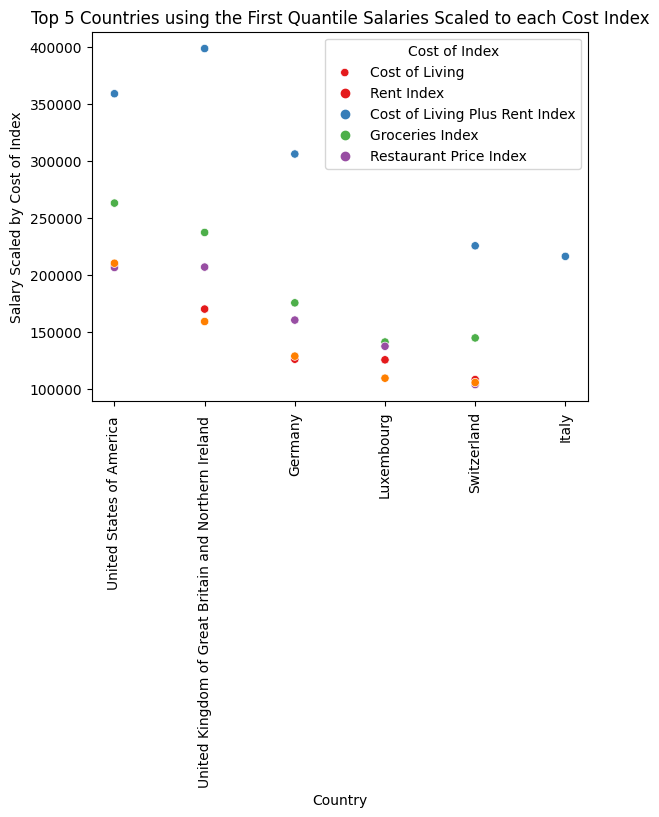

In terms of the first quantile the following are the lists of countries where salary goes the farthest:

The 5 countries in which salary goes the farthest on the Cost of Living index are:

United States of America 
United Kingdom of Great Britain and Northern Ireland 
Germany
Luxembourg
Switzerland
The 5 countries in which salary goes the farthest on the Rent index are:

United Kingdom of Great Britain and Northern Ireland 
United States of America 
Germany
Switzerland
Italy
The 5 countries in which salary goes the farthest on the Cost of Living plus Rent index are:

United States of America 
United Kingdom of Great Britain and Northern Ireland 
Germany
Switzerland
Luxembourg
The 5 countries in which salary goes the farthest on the Groceries index are:

United Kingdom of Great Britain and Northern Ireland 
United States of America 
Germany
Luxembourg
Switzerland
The 5 countries in which salary goes the farthest on the Restaurant Price index are:

United States of America 
United Kingdo

In [30]:
top_5_cost_of_living_q1 = salary_percentile_df.nlargest(5, 'cost_of_living_scaled_q1')    
top_5_cost_of_living_q1 = top_5_cost_of_living_q1[['employee_residence', 'cost_of_living_scaled_q1']]


top_5_rent_index_scaled_q1 = salary_percentile_df.nlargest(5, 'rent_index_scaled_q1') 
top_5_rent_index_scaled_q1  = top_5_rent_index_scaled_q1[['employee_residence', 'rent_index_scaled_q1']]


top_5_cost_of_living_plus_rent_index_scaled_q1= salary_percentile_df.nlargest(5, 'cost_of_living_plus_rent_index_scaled_q1')
top_5_cost_of_living_plus_rent_index_scaled_q1 = top_5_cost_of_living_plus_rent_index_scaled_q1[['employee_residence', 'cost_of_living_plus_rent_index_scaled_q1']]


top_5_groceries_index_scaled_q1 = salary_percentile_df.nlargest(5, 'groceries_index_scaled_q1')
top_5_groceries_index_scaled_q1 = top_5_groceries_index_scaled_q1[['employee_residence', 'groceries_index_scaled_q1']]


top_5_restuarant_price_index_q1 = salary_percentile_df.nlargest(5, 'restuarant_price_index_q1')
top_5_restuarant_price_index_q1 = top_5_restuarant_price_index_q1[['employee_residence', 'restuarant_price_index_q1']]
    

#merging
top_5_merged_q1 = pd.merge(top_5_cost_of_living_q1 , top_5_rent_index_scaled_q1 , how='outer', on='employee_residence')
top_5_merged_q1 = pd.merge(top_5_merged_q1 , top_5_cost_of_living_plus_rent_index_scaled_q1 , how='outer', on='employee_residence')
top_5_merged_q1 = pd.merge(top_5_merged_q1 , top_5_groceries_index_scaled_q1 , how='outer', on='employee_residence')
top_5_merged_q1 = pd.merge(top_5_merged_q1 , top_5_restuarant_price_index_q1 , how='outer', on='employee_residence')
    
top_5_merged_q1['country']=''

for idx, country_code in enumerate(top_5_merged_q1['employee_residence']):
    for key, value in country_code_dict.items():
        if country_code == value:
            top_5_merged_q1['country'][idx] = key
            

top_5_merged_q1 = top_5_merged_q1.drop(['employee_residence'], axis = 1)

print(top_5_merged_q1.head())
      
# convert to long (tidy) form
top_5_merged_q1_melted = top_5_merged_q1.melt('country', var_name='index_q1d', value_name='scaled_salary')
legend_labels = ['Cost of Living', 'Rent Index', 
        'Cost of Living Plus Rent Index', 
        'Groceries Index', 
        'Restaurant Price Index']

print(top_5_merged_q1_melted.head())



sns.scatterplot(data= top_5_merged_q1_melted, x ='country', y="scaled_salary",
                hue="index_q1d", legend = 'full',  palette=sns.color_palette("Set1", 5))
plt.title('Top 5 Countries using the First Quantile Salaries Scaled to each Cost Index')
plt.xlabel("Country")
plt.xticks(rotation=90)
plt.ylabel("Salary Scaled by Cost of Index")
plt.legend(title='Cost of Index', loc='upper right', 
           labels = legend_labels)                
plt.show()


# print countries of top 5 using print_countries function

print('In terms of the first quantile the following are the lists of countries where salary goes the farthest:\n')
print_countries('Cost of Living', top_5_cost_of_living_q1)
print_countries('Rent', top_5_rent_index_scaled_q1)
print_countries('Cost of Living plus Rent', top_5_cost_of_living_plus_rent_index_scaled_q1)
print_countries('Groceries', top_5_groceries_index_scaled_q1)
print_countries('Restaurant Price', top_5_restuarant_price_index_q1 )

   cost_of_living_scaled_median  rent_index_scaled_median  \
0                 273417.537730             469427.999040   
1                 221754.120163             519283.146800   
2                 149607.338159             362744.334840   
3                 132249.734553                       NaN   
4                 111486.182508             232127.149775   

   cost_of_living_plus_rent_index_scaled_median  \
0                                 344043.590645   
1                                 309234.297148   
2                                 208148.664728   
3                                 148677.939184   
4                                 149052.962790   

   groceries_index_scaled_median  restuarant_price_index_median  \
0                  270245.290055                  275109.097300   
1                  269714.939550                  207540.624695   
2                  190253.173151                  152799.934354   
3                  144736.983655                  115324.2

C:\Users\hawthorner\AppData\Local\Temp\ipykernel_22188\4077783730.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_5_merged_median['country'][idx] = key


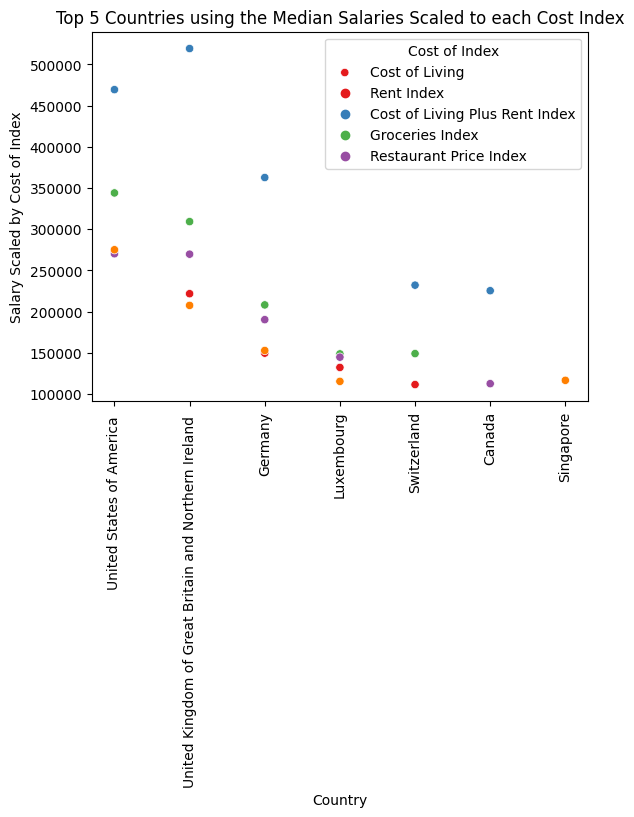

In terms of the median the following are the lists of countries where salary goes the farthest:

The 5 countries in which salary goes the farthest on the Cost of Living index are:

United States of America 
United Kingdom of Great Britain and Northern Ireland 
Germany
Luxembourg
Switzerland
The 5 countries in which salary goes the farthest on the Rent index are:

United Kingdom of Great Britain and Northern Ireland 
United States of America 
Germany
Switzerland
Canada
The 5 countries in which salary goes the farthest on the Cost of Living plus Rent index are:

United States of America 
United Kingdom of Great Britain and Northern Ireland 
Germany
Switzerland
Luxembourg
The 5 countries in which salary goes the farthest on the Groceries index are:

United States of America 
United Kingdom of Great Britain and Northern Ireland 
Germany
Luxembourg
Canada
The 5 countries in which salary goes the farthest on the Restaurant Price index are:

United States of America 
United Kingdom of Great B

In [33]:
# median 
top_5_cost_of_living_median = salary_percentile_df.nlargest(5, 'cost_of_living_scaled_median')    
top_5_cost_of_living_median = top_5_cost_of_living_median[['employee_residence', 'cost_of_living_scaled_median']]


top_5_rent_index_scaled_median = salary_percentile_df.nlargest(5, 'rent_index_scaled_median') 
top_5_rent_index_scaled_median  = top_5_rent_index_scaled_median[['employee_residence', 'rent_index_scaled_median']]


top_5_cost_of_living_plus_rent_index_scaled_median= salary_percentile_df.nlargest(5, 'cost_of_living_plus_rent_index_scaled_median')
top_5_cost_of_living_plus_rent_index_scaled_median = top_5_cost_of_living_plus_rent_index_scaled_median[['employee_residence', 'cost_of_living_plus_rent_index_scaled_median']]


top_5_groceries_index_scaled_median = salary_percentile_df.nlargest(5, 'groceries_index_scaled_median')
top_5_groceries_index_scaled_median = top_5_groceries_index_scaled_median[['employee_residence', 'groceries_index_scaled_median']]


top_5_restuarant_price_index_median = salary_percentile_df.nlargest(5, 'restuarant_price_index_median')
top_5_restuarant_price_index_median = top_5_restuarant_price_index_median[['employee_residence', 'restuarant_price_index_median']]
    

#merging
top_5_merged_median = pd.merge(top_5_cost_of_living_median , top_5_rent_index_scaled_median , how='outer', on='employee_residence')
top_5_merged_median = pd.merge(top_5_merged_median , top_5_cost_of_living_plus_rent_index_scaled_median , how='outer', on='employee_residence')
top_5_merged_median = pd.merge(top_5_merged_median , top_5_groceries_index_scaled_median , how='outer', on='employee_residence')
top_5_merged_median = pd.merge(top_5_merged_median , top_5_restuarant_price_index_median , how='outer', on='employee_residence')
    
top_5_merged_median['country']=''

for idx, country_code in enumerate(top_5_merged_median['employee_residence']):
    for key, value in country_code_dict.items():
        if country_code == value:
            top_5_merged_median['country'][idx] = key
            

top_5_merged_median = top_5_merged_median.drop(['employee_residence'], axis = 1)

print(top_5_merged_median.head())


# convert to long (tidy) form
top_5_merged_median_melted = top_5_merged_median.melt('country', var_name='index_mediand', value_name='scaled_salary')
legend_labels = ['Cost of Living', 'Rent Index', 
        'Cost of Living Plus Rent Index', 
        'Groceries Index', 
        'Restaurant Price Index']

print(top_5_merged_median_melted.head())


sns.scatterplot(data= top_5_merged_median_melted, x ='country', y="scaled_salary",
                hue="index_mediand", legend = 'full',  palette=sns.color_palette("Set1", 5))
plt.title('Top 5 Countries using the Median Salaries Scaled to each Cost Index')
plt.xlabel("Country")
plt.xticks(rotation=90)
plt.ylabel("Salary Scaled by Cost of Index")
plt.legend(title='Cost of Index', loc='upper right', 
           labels = legend_labels)                
plt.show()

# print countries of top 5 using print_countries function

print('In terms of the median the following are the lists of countries where salary goes the farthest:\n')
print_countries('Cost of Living', top_5_cost_of_living_median)
print_countries('Rent', top_5_rent_index_scaled_median)
print_countries('Cost of Living plus Rent', top_5_cost_of_living_plus_rent_index_scaled_median)
print_countries('Groceries', top_5_groceries_index_scaled_median)
print_countries('Restaurant Price', top_5_restuarant_price_index_median )

   cost_of_living_scaled_q3  rent_index_scaled_q3  \
0             348984.263611         599167.800000   
1             298713.361121         699499.130119   
2             175256.461362         424934.293236   
3             136393.569812         283987.216138   
4             132249.734553                   NaN   

   cost_of_living_plus_rent_index_scaled_q3  groceries_index_scaled_q3  \
0                             439129.838298              344935.274917   
1                             416553.325851              363318.869018   
2                             243834.285581              222870.738159   
3                             182353.231842              130923.888836   
4                                       NaN              144736.983655   

   restuarant_price_index_q3  \
0              351143.333858   
1              279567.105794   
2              178996.405664   
3              133150.450524   
4                        NaN   

                                           

C:\Users\hawthorner\AppData\Local\Temp\ipykernel_22188\2430392722.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_5_merged_q3['country'][idx] = key


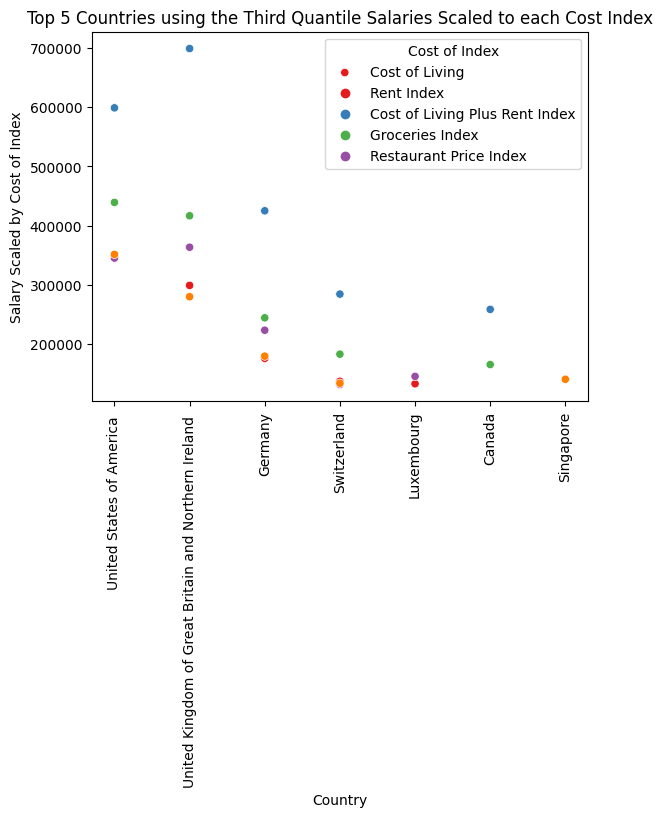

In terms of the third quantile the following are the lists of contries where salary goes the farthest:

The 5 countries in which salary goes the farthest on the Cost of Living index are:

United States of America 
United Kingdom of Great Britain and Northern Ireland 
Germany
Switzerland
Luxembourg
The 5 countries in which salary goes the farthest on the Rent index are:

United Kingdom of Great Britain and Northern Ireland 
United States of America 
Germany
Switzerland
Canada
The 5 countries in which salary goes the farthest on the Cost of Living plus Rent index are:

United States of America 
United Kingdom of Great Britain and Northern Ireland 
Germany
Switzerland
Canada
The 5 countries in which salary goes the farthest on the Groceries index are:

United Kingdom of Great Britain and Northern Ireland 
United States of America 
Germany
Luxembourg
Switzerland
The 5 countries in which salary goes the farthest on the Restaurant Price index are:

United States of America 
United Kingdom of

In [34]:
# third quantile 
top_5_cost_of_living_q3 = salary_percentile_df.nlargest(5, 'cost_of_living_scaled_q3')    
top_5_cost_of_living_q3 = top_5_cost_of_living_q3[['employee_residence', 'cost_of_living_scaled_q3']]


top_5_rent_index_scaled_q3 = salary_percentile_df.nlargest(5, 'rent_index_scaled_q3') 
top_5_rent_index_scaled_q3  = top_5_rent_index_scaled_q3[['employee_residence', 'rent_index_scaled_q3']]


top_5_cost_of_living_plus_rent_index_scaled_q3= salary_percentile_df.nlargest(5, 'cost_of_living_plus_rent_index_scaled_q3')
top_5_cost_of_living_plus_rent_index_scaled_q3 = top_5_cost_of_living_plus_rent_index_scaled_q3[['employee_residence', 'cost_of_living_plus_rent_index_scaled_q3']]


top_5_groceries_index_scaled_q3 = salary_percentile_df.nlargest(5, 'groceries_index_scaled_q3')
top_5_groceries_index_scaled_q3 = top_5_groceries_index_scaled_q3[['employee_residence', 'groceries_index_scaled_q3']]


top_5_restuarant_price_index_q3 = salary_percentile_df.nlargest(5, 'restuarant_price_index_q3')
top_5_restuarant_price_index_q3 = top_5_restuarant_price_index_q3[['employee_residence', 'restuarant_price_index_q3']]
    

#merging
top_5_merged_q3 = pd.merge(top_5_cost_of_living_q3 , top_5_rent_index_scaled_q3 , how='outer', on='employee_residence')
top_5_merged_q3 = pd.merge(top_5_merged_q3 , top_5_cost_of_living_plus_rent_index_scaled_q3 , how='outer', on='employee_residence')
top_5_merged_q3 = pd.merge(top_5_merged_q3 , top_5_groceries_index_scaled_q3 , how='outer', on='employee_residence')
top_5_merged_q3 = pd.merge(top_5_merged_q3 , top_5_restuarant_price_index_q3 , how='outer', on='employee_residence')
    
top_5_merged_q3['country']=''

for idx, country_code in enumerate(top_5_merged_q3['employee_residence']):
    for key, value in country_code_dict.items():
        if country_code == value:
            top_5_merged_q3['country'][idx] = key
            

top_5_merged_q3 = top_5_merged_q3.drop(['employee_residence'], axis = 1)

print(top_5_merged_q3.head())
# convert to long (tidy) form
top_5_merged_q3_melted = top_5_merged_q3.melt('country', var_name='index_q3d', value_name='scaled_salary')
legend_labels = ['Cost of Living', 'Rent Index', 
        'Cost of Living Plus Rent Index', 
        'Groceries Index', 
        'Restaurant Price Index']

print(top_5_merged_q3_melted.head())


sns.scatterplot(data= top_5_merged_q3_melted, x ='country', y="scaled_salary",
                hue="index_q3d", legend = 'full',  palette=sns.color_palette("Set1", 5))
plt.title('Top 5 Countries using the Third Quantile Salaries Scaled to each Cost Index')
plt.xlabel("Country")
plt.xticks(rotation=90)
plt.ylabel("Salary Scaled by Cost of Index")
plt.legend(title='Cost of Index', loc='upper right', 
           labels = legend_labels)                
plt.show()


# print countries of top 5 using print_countries function

print('In terms of the third quantile the following are the lists of contries where salary goes the farthest:\n')
print_countries('Cost of Living', top_5_cost_of_living_q3)
print_countries('Rent', top_5_rent_index_scaled_q3)
print_countries('Cost of Living plus Rent', top_5_cost_of_living_plus_rent_index_scaled_q3)
print_countries('Groceries', top_5_groceries_index_scaled_q3)
print_countries('Restaurant Price', top_5_restuarant_price_index_q3 )


The United States was top 1 or 2 on each index for each salary measure. This was for the US as a whole. 
Now I consider just the US

Go back to salary_df and cost_of_living_df and filter for just US

Add quantile to us salary information


In [35]:
salary_us_df = salary_df[salary_df['employee_residence']=='US']

salary_us_quartile_df = salary_us_df.groupby(['city', 'state']).agg(
    first_quantile = ('salary_in_2023' , lambda x: np.percentile(x, q=25)),
    median = ('salary_in_2023' , lambda x: np.percentile(x, q=50)),
    third_quantile = ('salary_in_2023' , lambda x: np.percentile(x, q=75))       
    )

cost_of_living_us_df = cost_of_living_df[cost_of_living_df['employee_residence']=='US']


print(salary_us_quartile_df.head())
print(cost_of_living_us_df.head())

                    first_quantile         median  third_quantile
city         state                                               
Albuquerque  NM      145902.476293  145902.476293   145902.476293
Alpharetta   GA      120121.760000  120121.760000   120121.760000
Ann Arbor    MI      200549.029750  200549.029750   200549.029750
Antioch      TN      149839.883424  149839.883424   149839.883424
Arizona City AZ      114163.720704  135569.418336   156975.115968
    Rank                              City  Cost of Living Index  Rent Index  \
10   NaN       Honolulu, HI, United States                103.65       65.07   
13   NaN       New York, NY, United States                100.00      100.00   
18   NaN  Santa Barbara, CA, United States                 95.01       78.42   
20   NaN       Berkeley, CA, United States                 94.36       88.22   
21   NaN  San Francisco, CA, United States                 93.91      108.42   

    Cost of Living Plus Rent Index  Groceries Index  Rest

Note there are no duplicate cities in the cost of living index data, 
so unlike when grouped by country there is no measures of central tendency to 
calculate when we look at cities individually.

merge cost of living and salary data, then scale salary by each cost of living 
index

In [36]:
us_salary_cost_of_living_merge_df = pd.merge(salary_us_quartile_df , 
                                             cost_of_living_us_df,
                                             how='outer', on=['city', 'state'])


print(us_salary_cost_of_living_merge_df.head())

           city state  first_quantile         median  third_quantile  Rank  \
0   Albuquerque    NM   145902.476293  145902.476293   145902.476293   NaN   
1    Alpharetta    GA   120121.760000  120121.760000   120121.760000   NaN   
2     Ann Arbor    MI   200549.029750  200549.029750   200549.029750   NaN   
3       Antioch    TN   149839.883424  149839.883424   149839.883424   NaN   
4  Arizona City    AZ   114163.720704  135569.418336   156975.115968   NaN   

                             City  Cost of Living Index  Rent Index  \
0  Albuquerque, NM, United States                 63.44       33.91   
1                             NaN                   NaN         NaN   
2    Ann Arbor, MI, United States                 70.28       47.97   
3                             NaN                   NaN         NaN   
4                             NaN                   NaN         NaN   

   Cost of Living Plus Rent Index  Groceries Index  Restaurant Price Index  \
0                         

remove the rank column which is all nan

drops rows that contain nan as they either are missing salary or index data

In [37]:
us_salary_cost_of_living_merge_drop_df= us_salary_cost_of_living_merge_df.drop(['Rank'], axis = 1)

us_salary_cost_of_living_merge_drop_df = us_salary_cost_of_living_merge_drop_df.dropna(axis = 0)

us_salary_cost_of_living_merge_drop_df= us_salary_cost_of_living_merge_drop_df.reset_index(drop=True)


print(us_salary_cost_of_living_merge_drop_df.head())

          city state  first_quantile         median  third_quantile  \
0  Albuquerque    NM   145902.476293  145902.476293   145902.476293   
1    Ann Arbor    MI   200549.029750  200549.029750   200549.029750   
2      Atlanta    GA   122488.158672  141962.080000   154596.705120   
3       Austin    TX   126871.718516  146330.144000   175774.171408   
4     Berkeley    CA   319166.443687  338732.202687   358297.961687   

                             City  Cost of Living Index  Rent Index  \
0  Albuquerque, NM, United States                 63.44       33.91   
1    Ann Arbor, MI, United States                 70.28       47.97   
2      Atlanta, GA, United States                 76.60       48.58   
3       Austin, TX, United States                 66.50       57.68   
4     Berkeley, CA, United States                 94.36       88.22   

   Cost of Living Plus Rent Index  Groceries Index  Restaurant Price Index  \
0                           49.60            64.60                  

Calculate scaled salaries for each index and convert to numeric

In [40]:
us_salary_cost_of_living_merge_drop_df['cost_of_living_scaled_q1']=''
us_salary_cost_of_living_merge_drop_df['rent_index_scaled_q1']=''
us_salary_cost_of_living_merge_drop_df['cost_of_living_plus_rent_index_scaled_q1']=''
us_salary_cost_of_living_merge_drop_df['groceries_index_scaled_q1']=''
us_salary_cost_of_living_merge_drop_df['restuarant_price_index_q1']=''  

us_salary_cost_of_living_merge_drop_df['cost_of_living_scaled_median']=''
us_salary_cost_of_living_merge_drop_df['rent_index_scaled_median']=''
us_salary_cost_of_living_merge_drop_df['cost_of_living_plus_rent_index_scaled_median']=''
us_salary_cost_of_living_merge_drop_df['groceries_index_scaled_median']=''
us_salary_cost_of_living_merge_drop_df['restuarant_price_index_median']='' 


us_salary_cost_of_living_merge_drop_df['cost_of_living_scaled_q3']=''
us_salary_cost_of_living_merge_drop_df['rent_index_scaled_q3']=''
us_salary_cost_of_living_merge_drop_df['cost_of_living_plus_rent_index_scaled_q3']=''
us_salary_cost_of_living_merge_drop_df['groceries_index_scaled_q3']=''
us_salary_cost_of_living_merge_drop_df['restuarant_price_index_q3']='' 

for idx, salary in enumerate(us_salary_cost_of_living_merge_drop_df['first_quantile']):
    us_salary_cost_of_living_merge_drop_df['cost_of_living_scaled_q1'][idx] = salary*100/us_salary_cost_of_living_merge_drop_df['Cost of Living Index'][idx]
    us_salary_cost_of_living_merge_drop_df['rent_index_scaled_q1'][idx] = salary*100/us_salary_cost_of_living_merge_drop_df['Rent Index'][idx]
    us_salary_cost_of_living_merge_drop_df['cost_of_living_plus_rent_index_scaled_q1'][idx] = salary*100/us_salary_cost_of_living_merge_drop_df['Cost of Living Plus Rent Index'][idx]
    us_salary_cost_of_living_merge_drop_df['groceries_index_scaled_q1'][idx] = salary*100/us_salary_cost_of_living_merge_drop_df['Groceries Index'][idx]
    us_salary_cost_of_living_merge_drop_df['restuarant_price_index_q1'][idx] = salary*100/us_salary_cost_of_living_merge_drop_df['Restaurant Price Index'][idx]


for idx, salary in enumerate(us_salary_cost_of_living_merge_drop_df['median']):
    us_salary_cost_of_living_merge_drop_df['cost_of_living_scaled_median'][idx] = salary*100/us_salary_cost_of_living_merge_drop_df['Cost of Living Index'][idx]
    us_salary_cost_of_living_merge_drop_df['rent_index_scaled_median'][idx] = salary*100/us_salary_cost_of_living_merge_drop_df['Rent Index'][idx]
    us_salary_cost_of_living_merge_drop_df['cost_of_living_plus_rent_index_scaled_median'][idx] = salary*100/us_salary_cost_of_living_merge_drop_df['Cost of Living Plus Rent Index'][idx]
    us_salary_cost_of_living_merge_drop_df['groceries_index_scaled_median'][idx] = salary*100/us_salary_cost_of_living_merge_drop_df['Groceries Index'][idx]
    us_salary_cost_of_living_merge_drop_df['restuarant_price_index_median'][idx] = salary*100/us_salary_cost_of_living_merge_drop_df['Restaurant Price Index'][idx]


for idx, salary in enumerate(us_salary_cost_of_living_merge_drop_df['third_quantile']):
    us_salary_cost_of_living_merge_drop_df['cost_of_living_scaled_q3'][idx] = salary*100/us_salary_cost_of_living_merge_drop_df['Cost of Living Index'][idx]
    us_salary_cost_of_living_merge_drop_df['rent_index_scaled_q3'][idx] = salary*100/us_salary_cost_of_living_merge_drop_df['Rent Index'][idx]
    us_salary_cost_of_living_merge_drop_df['cost_of_living_plus_rent_index_scaled_q3'][idx] = salary*100/us_salary_cost_of_living_merge_drop_df['Cost of Living Plus Rent Index'][idx]
    us_salary_cost_of_living_merge_drop_df['groceries_index_scaled_q3'][idx] = salary*100/us_salary_cost_of_living_merge_drop_df['Groceries Index'][idx]
    us_salary_cost_of_living_merge_drop_df['restuarant_price_index_q3'][idx] = salary*100/us_salary_cost_of_living_merge_drop_df['Restaurant Price Index'][idx]

us_salary_cost_of_living_merge_drop_df['cost_of_living_scaled_q1'] = pd.to_numeric(us_salary_cost_of_living_merge_drop_df['cost_of_living_scaled_q1'], errors='coerce')
us_salary_cost_of_living_merge_drop_df['rent_index_scaled_q1'] = pd.to_numeric(us_salary_cost_of_living_merge_drop_df['rent_index_scaled_q1'], errors='coerce')
us_salary_cost_of_living_merge_drop_df['cost_of_living_plus_rent_index_scaled_q1'] = pd.to_numeric(us_salary_cost_of_living_merge_drop_df['cost_of_living_plus_rent_index_scaled_q1'], errors='coerce')
us_salary_cost_of_living_merge_drop_df['groceries_index_scaled_q1'] = pd.to_numeric(us_salary_cost_of_living_merge_drop_df['groceries_index_scaled_q1'], errors='coerce')
us_salary_cost_of_living_merge_drop_df['restuarant_price_index_q1'] = pd.to_numeric(us_salary_cost_of_living_merge_drop_df['restuarant_price_index_q1'], errors='coerce')    

us_salary_cost_of_living_merge_drop_df['cost_of_living_scaled_median'] = pd.to_numeric(us_salary_cost_of_living_merge_drop_df['cost_of_living_scaled_median'], errors='coerce')
us_salary_cost_of_living_merge_drop_df['rent_index_scaled_median'] = pd.to_numeric(us_salary_cost_of_living_merge_drop_df['rent_index_scaled_median'], errors='coerce')
us_salary_cost_of_living_merge_drop_df['cost_of_living_plus_rent_index_scaled_median'] = pd.to_numeric(us_salary_cost_of_living_merge_drop_df['cost_of_living_plus_rent_index_scaled_median'], errors='coerce')
us_salary_cost_of_living_merge_drop_df['groceries_index_scaled_median'] = pd.to_numeric(us_salary_cost_of_living_merge_drop_df['groceries_index_scaled_median'], errors='coerce')
us_salary_cost_of_living_merge_drop_df['restuarant_price_index_median'] = pd.to_numeric(us_salary_cost_of_living_merge_drop_df['restuarant_price_index_median'], errors='coerce')    


us_salary_cost_of_living_merge_drop_df['cost_of_living_scaled_q3'] = pd.to_numeric(us_salary_cost_of_living_merge_drop_df['cost_of_living_scaled_q3'], errors='coerce')
us_salary_cost_of_living_merge_drop_df['rent_index_scaled_q3'] = pd.to_numeric(us_salary_cost_of_living_merge_drop_df['rent_index_scaled_q3'], errors='coerce')
us_salary_cost_of_living_merge_drop_df['cost_of_living_plus_rent_index_scaled_q3'] = pd.to_numeric(us_salary_cost_of_living_merge_drop_df['cost_of_living_plus_rent_index_scaled_q3'], errors='coerce')
us_salary_cost_of_living_merge_drop_df['groceries_index_scaled_q3'] = pd.to_numeric(us_salary_cost_of_living_merge_drop_df['groceries_index_scaled_q3'], errors='coerce')
us_salary_cost_of_living_merge_drop_df['restuarant_price_index_q3'] = pd.to_numeric(us_salary_cost_of_living_merge_drop_df['restuarant_price_index_q3'], errors='coerce')    


print(us_salary_cost_of_living_merge_drop_df.head())

          city state  first_quantile         median  third_quantile  \
0  Albuquerque    NM   145902.476293  145902.476293   145902.476293   
1    Ann Arbor    MI   200549.029750  200549.029750   200549.029750   
2      Atlanta    GA   122488.158672  141962.080000   154596.705120   
3       Austin    TX   126871.718516  146330.144000   175774.171408   
4     Berkeley    CA   319166.443687  338732.202687   358297.961687   

                             City  Cost of Living Index  Rent Index  \
0  Albuquerque, NM, United States                 63.44       33.91   
1    Ann Arbor, MI, United States                 70.28       47.97   
2      Atlanta, GA, United States                 76.60       48.58   
3       Austin, TX, United States                 66.50       57.68   
4     Berkeley, CA, United States                 94.36       88.22   

   Cost of Living Plus Rent Index  Groceries Index  ...  \
0                           49.60            64.60  ...   
1                           

C:\Users\hawthorner\AppData\Local\Temp\ipykernel_22188\94921046.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_salary_cost_of_living_merge_drop_df['cost_of_living_scaled_q1'][idx] = salary*100/us_salary_cost_of_living_merge_drop_df['Cost of Living Index'][idx]
C:\Users\hawthorner\AppData\Local\Temp\ipykernel_22188\94921046.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_salary_cost_of_living_merge_drop_df['rent_index_scaled_q1'][idx] = salary*100/us_salary_cost_of_living_merge_drop_df['Rent Index'][idx]
C:\Users\hawthorner\AppData\Local\Temp\ipykernel_22188\94921046.py:23: SettingWithCopyWarning: 
A va

finding top 5 of each indice, which returns all columnns.
so I removed all columns except the residency 
and the column its actually the top 5 of.

Then created a graphic and printed the top 5 for each index.

This was repeated with each of the first quantile, median, and third quantile.

                            City  cost_of_living_scaled_q1  \
0    Berkeley, CA, United States             338243.369741   
1     Fremont, CA, United States             292997.866728   
2   Ann Arbor, MI, United States             285357.185188   
3  Sacramento, CA, United States             259585.159322   
4    San Jose, CA, United States             248053.634432   

   rent_index_scaled_q1  cost_of_living_plus_rent_index_scaled_q1  \
0                   NaN                             348892.046007   
1                   NaN                             291503.380965   
2         418071.773504                             335254.145353   
3         399930.607478                             310688.369571   
4                   NaN                                       NaN   

   groceries_index_scaled_q1  restuarant_price_index_q1  
0              300448.502012              404776.719959  
1              288023.897638              305873.265942  
2              270427.494269          

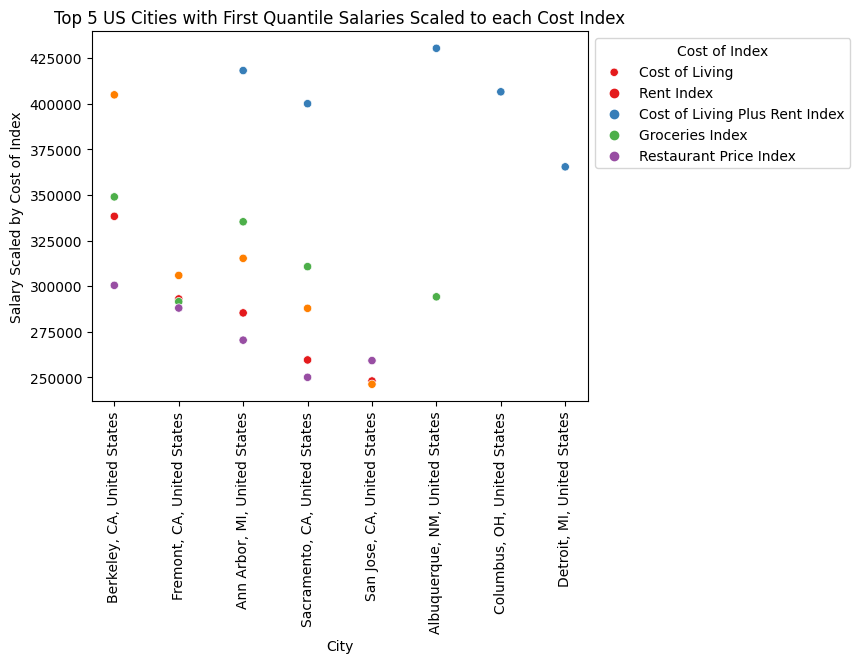

The top five cities for each index for the first quantile of salaries are:

The 5 cities in which salary goes the farthest on the Cost of Living index are:
Berkeley, CA, United States
Fremont, CA, United States
Ann Arbor, MI, United States
Sacramento, CA, United States
San Jose, CA, United States
The 5 cities in which salary goes the farthest on the Rent index are:
Albuquerque, NM, United States
Ann Arbor, MI, United States
Columbus, OH, United States
Sacramento, CA, United States
Detroit, MI, United States
The 5 cities in which salary goes the farthest on the Cost of Living plus Rent index are:
Berkeley, CA, United States
Ann Arbor, MI, United States
Sacramento, CA, United States
Albuquerque, NM, United States
Fremont, CA, United States
The 5 cities in which salary goes the farthest on the Groceries index are:
Berkeley, CA, United States
Fremont, CA, United States
Ann Arbor, MI, United States
San Jose, CA, United States
Sacramento, CA, United States
The 5 cities in which salary goes t

In [47]:
# first quantile

top_5_cost_of_living_us_q1 = us_salary_cost_of_living_merge_drop_df.nlargest(5, 'cost_of_living_scaled_q1')    
top_5_cost_of_living_us_q1 = top_5_cost_of_living_us_q1[['City', 'cost_of_living_scaled_q1']]


top_5_rent_index_scaled_us_q1 = us_salary_cost_of_living_merge_drop_df.nlargest(5, 'rent_index_scaled_q1') 
top_5_rent_index_scaled_us_q1  = top_5_rent_index_scaled_us_q1[['City', 'rent_index_scaled_q1']]


top_5_cost_of_living_plus_rent_index_scaled_us_q1 = us_salary_cost_of_living_merge_drop_df.nlargest(5, 'cost_of_living_plus_rent_index_scaled_q1')
top_5_cost_of_living_plus_rent_index_scaled_us_q1 = top_5_cost_of_living_plus_rent_index_scaled_us_q1[['City', 'cost_of_living_plus_rent_index_scaled_q1']]


top_5_groceries_index_scaled_us_q1 = us_salary_cost_of_living_merge_drop_df.nlargest(5, 'groceries_index_scaled_q1')
top_5_groceries_index_scaled_us_q1 = top_5_groceries_index_scaled_us_q1[['City', 'groceries_index_scaled_q1']]


top_5_restuarant_price_index_us_q1 = us_salary_cost_of_living_merge_drop_df.nlargest(5, 'restuarant_price_index_q1')
top_5_restuarant_price_index_us_q1 = top_5_restuarant_price_index_us_q1[['City', 'restuarant_price_index_q1']]
    


#merging
top_5_merged_us_q1 = pd.merge(top_5_cost_of_living_us_q1 , top_5_rent_index_scaled_us_q1 , how='outer', on='City')
top_5_merged_us_q1 = pd.merge(top_5_merged_us_q1 , top_5_cost_of_living_plus_rent_index_scaled_us_q1 , how='outer', on='City')
top_5_merged_us_q1 = pd.merge(top_5_merged_us_q1 , top_5_groceries_index_scaled_us_q1 , how='outer', on='City')
top_5_merged_us_q1 = pd.merge(top_5_merged_us_q1 , top_5_restuarant_price_index_us_q1 , how='outer', on='City')

print(top_5_merged_us_q1.head())

# convert to long (tidy) form
top_5_merged_melted_us_q1 = top_5_merged_us_q1.melt('City', var_name='index_measured', value_name='scaled_salary')

print(top_5_merged_melted_us_q1.head())
legend_labels = ['Cost of Living', 'Rent Index', 
        'Cost of Living Plus Rent Index', 
        'Groceries Index', 
        'Restaurant Price Index']

ax = sns.scatterplot(data= top_5_merged_melted_us_q1, x ='City', y="scaled_salary",
                hue="index_measured", palette=sns.color_palette("Set1", 5))
plt.title('Top 5 US Cities with First Quantile Salaries Scaled to each Cost Index')
plt.xlabel("City")
plt.xticks(rotation=90)
plt.ylabel("Salary Scaled by Cost of Index")
plt.legend(title='Cost of Index', 
           labels = legend_labels)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()                

# print countries of top 5 using print_countries function

print('The top five cities for each index for the first quantile of salaries are:\n')
print_cities('Cost of Living', top_5_cost_of_living_us_q1)
print_cities('Rent', top_5_rent_index_scaled_us_q1)
print_cities('Cost of Living plus Rent', top_5_cost_of_living_plus_rent_index_scaled_us_q1)
print_cities('Groceries', top_5_groceries_index_scaled_us_q1)
print_cities('Restaurant Price', top_5_restuarant_price_index_us_q1 )


                           City  cost_of_living_scaled_median  \
0   Berkeley, CA, United States                 358978.595472   
1    Fremont, CA, United States                 305220.032970   
2   San Jose, CA, United States                 288842.009833   
3  Ann Arbor, MI, United States                 285357.185188   
4  San Diego, CA, United States                 264723.083652   

   rent_index_scaled_median  cost_of_living_plus_rent_index_scaled_median  \
0                       NaN                                 370280.064153   
1                       NaN                                 303663.205956   
2                       NaN                                           NaN   
3             418071.773504                                 335254.145353   
4                       NaN                                           NaN   

   groceries_index_scaled_median  restuarant_price_index_median  
0                  318866.800986                  429590.618500  
1             

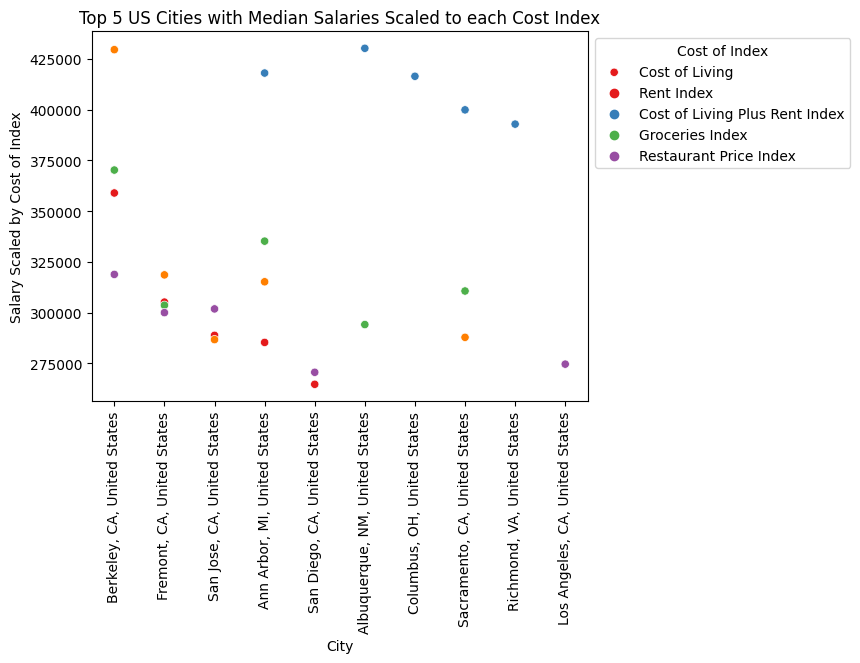

The 5 cities in which salary goes the farthest on the Cost of Living index are:
Berkeley, CA, United States
Fremont, CA, United States
San Jose, CA, United States
Ann Arbor, MI, United States
San Diego, CA, United States
The 5 cities in which salary goes the farthest on the Rent index are:
Albuquerque, NM, United States
Ann Arbor, MI, United States
Columbus, OH, United States
Sacramento, CA, United States
Richmond, VA, United States
The 5 cities in which salary goes the farthest on the Cost of Living plus Rent index are:
Berkeley, CA, United States
Ann Arbor, MI, United States
Sacramento, CA, United States
Fremont, CA, United States
Albuquerque, NM, United States
The 5 cities in which salary goes the farthest on the Groceries index are:
Berkeley, CA, United States
San Jose, CA, United States
Fremont, CA, United States
Los Angeles, CA, United States
San Diego, CA, United States
The 5 cities in which salary goes the farthest on the Restaurant Price index are:
Berkeley, CA, United States


In [48]:
top_5_cost_of_living_us_median = us_salary_cost_of_living_merge_drop_df.nlargest(5, 'cost_of_living_scaled_median')    
top_5_cost_of_living_us_median = top_5_cost_of_living_us_median[['City', 'cost_of_living_scaled_median']]


top_5_rent_index_scaled_us_median = us_salary_cost_of_living_merge_drop_df.nlargest(5, 'rent_index_scaled_median') 
top_5_rent_index_scaled_us_median  = top_5_rent_index_scaled_us_median[['City', 'rent_index_scaled_median']]


top_5_cost_of_living_plus_rent_index_scaled_us_median = us_salary_cost_of_living_merge_drop_df.nlargest(5, 'cost_of_living_plus_rent_index_scaled_median')
top_5_cost_of_living_plus_rent_index_scaled_us_median = top_5_cost_of_living_plus_rent_index_scaled_us_median[['City', 'cost_of_living_plus_rent_index_scaled_median']]


top_5_groceries_index_scaled_us_median = us_salary_cost_of_living_merge_drop_df.nlargest(5, 'groceries_index_scaled_median')
top_5_groceries_index_scaled_us_median = top_5_groceries_index_scaled_us_median[['City', 'groceries_index_scaled_median']]


top_5_restuarant_price_index_us_median = us_salary_cost_of_living_merge_drop_df.nlargest(5, 'restuarant_price_index_median')
top_5_restuarant_price_index_us_median = top_5_restuarant_price_index_us_median[['City', 'restuarant_price_index_median']]
    


#merging
top_5_merged_us_median = pd.merge(top_5_cost_of_living_us_median , top_5_rent_index_scaled_us_median , how='outer', on='City')
top_5_merged_us_median = pd.merge(top_5_merged_us_median , top_5_cost_of_living_plus_rent_index_scaled_us_median , how='outer', on='City')
top_5_merged_us_median = pd.merge(top_5_merged_us_median , top_5_groceries_index_scaled_us_median , how='outer', on='City')
top_5_merged_us_median = pd.merge(top_5_merged_us_median , top_5_restuarant_price_index_us_median , how='outer', on='City')

print(top_5_merged_us_median.head())


# convert to long (tidy) form
top_5_merged_melted_us_median = top_5_merged_us_median.melt('City', var_name='index_measured', value_name='scaled_salary')

print(top_5_merged_melted_us_median.head())


ax = sns.scatterplot(data= top_5_merged_melted_us_median, x ='City', y="scaled_salary",
                hue="index_measured", palette=sns.color_palette("Set1", 5))
plt.title('Top 5 US Cities with Median Salaries Scaled to each Cost Index')
plt.xlabel("City")
plt.xticks(rotation=90)
plt.ylabel("Salary Scaled by Cost of Index")
plt.legend(title='Cost of Index', 
           labels = legend_labels)  
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()                

# print countries of top 5 using print_countries function


print_cities('Cost of Living', top_5_cost_of_living_us_median)
print_cities('Rent', top_5_rent_index_scaled_us_median)
print_cities('Cost of Living plus Rent', top_5_cost_of_living_plus_rent_index_scaled_us_median)
print_cities('Groceries', top_5_groceries_index_scaled_us_median)
print_cities('Restaurant Price', top_5_restuarant_price_index_us_median )



                               City  cost_of_living_scaled_q3  \
0       Berkeley, CA, United States             379713.821203   
1    Los Angeles, CA, United States             330376.554211   
2        Fremont, CA, United States             321075.436776   
3       San Jose, CA, United States             318557.978374   
4  San Francisco, CA, United States             317483.269632   

   rent_index_scaled_q3  cost_of_living_plus_rent_index_scaled_q3  \
0                   NaN                             391668.082299   
1                   NaN                             339861.253936   
2                   NaN                                       NaN   
3                   NaN                                       NaN   
4                   NaN                                       NaN   

   groceries_index_scaled_q3  restuarant_price_index_q3  
0              337285.099960              454404.517042  
1              344515.661417                        NaN  
2              31562

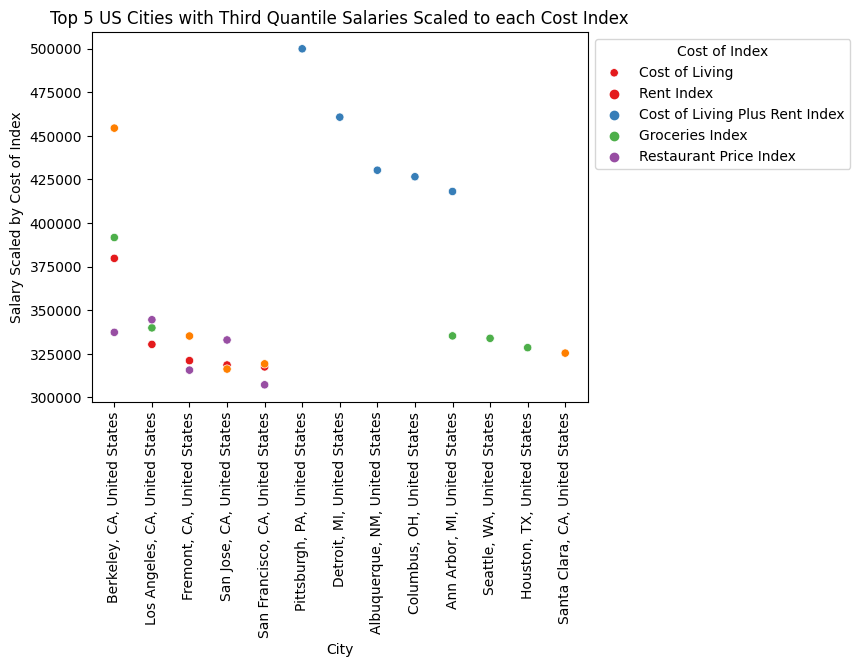

The top five cities for each index for the third quantile of salaries are:

The 5 cities in which salary goes the farthest on the Cost of Living index are:
Berkeley, CA, United States
Los Angeles, CA, United States
Fremont, CA, United States
San Jose, CA, United States
San Francisco, CA, United States
The 5 cities in which salary goes the farthest on the Rent index are:
Pittsburgh, PA, United States
Detroit, MI, United States
Albuquerque, NM, United States
Columbus, OH, United States
Ann Arbor, MI, United States
The 5 cities in which salary goes the farthest on the Cost of Living plus Rent index are:
Berkeley, CA, United States
Los Angeles, CA, United States
Ann Arbor, MI, United States
Seattle, WA, United States
Houston, TX, United States
The 5 cities in which salary goes the farthest on the Groceries index are:
Los Angeles, CA, United States
Berkeley, CA, United States
San Jose, CA, United States
Fremont, CA, United States
San Francisco, CA, United States
The 5 cities in which salary

In [49]:

#third qunatile
top_5_cost_of_living_us_q3 = us_salary_cost_of_living_merge_drop_df.nlargest(5, 'cost_of_living_scaled_q3')    
top_5_cost_of_living_us_q3 = top_5_cost_of_living_us_q3[['City', 'cost_of_living_scaled_q3']]


top_5_rent_index_scaled_us_q3 = us_salary_cost_of_living_merge_drop_df.nlargest(5, 'rent_index_scaled_q3') 
top_5_rent_index_scaled_us_q3  = top_5_rent_index_scaled_us_q3[['City', 'rent_index_scaled_q3']]


top_5_cost_of_living_plus_rent_index_scaled_us_q3 = us_salary_cost_of_living_merge_drop_df.nlargest(5, 'cost_of_living_plus_rent_index_scaled_q3')
top_5_cost_of_living_plus_rent_index_scaled_us_q3 = top_5_cost_of_living_plus_rent_index_scaled_us_q3[['City', 'cost_of_living_plus_rent_index_scaled_q3']]


top_5_groceries_index_scaled_us_q3 = us_salary_cost_of_living_merge_drop_df.nlargest(5, 'groceries_index_scaled_q3')
top_5_groceries_index_scaled_us_q3 = top_5_groceries_index_scaled_us_q3[['City', 'groceries_index_scaled_q3']]


top_5_restuarant_price_index_us_q3 = us_salary_cost_of_living_merge_drop_df.nlargest(5, 'restuarant_price_index_q3')
top_5_restuarant_price_index_us_q3 = top_5_restuarant_price_index_us_q3[['City', 'restuarant_price_index_q3']]
    


#merging
top_5_merged_us_q3 = pd.merge(top_5_cost_of_living_us_q3 , top_5_rent_index_scaled_us_q3 , how='outer', on='City')
top_5_merged_us_q3 = pd.merge(top_5_merged_us_q3 , top_5_cost_of_living_plus_rent_index_scaled_us_q3 , how='outer', on='City')
top_5_merged_us_q3 = pd.merge(top_5_merged_us_q3 , top_5_groceries_index_scaled_us_q3 , how='outer', on='City')
top_5_merged_us_q3 = pd.merge(top_5_merged_us_q3 , top_5_restuarant_price_index_us_q3 , how='outer', on='City')

print(top_5_merged_us_q3.head())

# convert to long (tidy) form
top_5_merged_melted_us_q3 = top_5_merged_us_q3.melt('City', var_name='index_measured', value_name='scaled_salary')
print(top_5_merged_melted_us_q3.head())


ax = sns.scatterplot(data= top_5_merged_melted_us_q3, x ='City', y="scaled_salary",
                hue="index_measured", palette=sns.color_palette("Set1", 5))
plt.title('Top 5 US Cities with Third Quantile Salaries Scaled to each Cost Index')
plt.xlabel("City")
plt.xticks(rotation=90)
plt.ylabel("Salary Scaled by Cost of Index")
plt.legend(title='Cost of Index', 
           labels = legend_labels)    
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))            
plt.show()                

# print countries of top 5 using print_countries function

print('The top five cities for each index for the third quantile of salaries are:\n')
print_cities('Cost of Living', top_5_cost_of_living_us_q3)
print_cities('Rent', top_5_rent_index_scaled_us_q3)
print_cities('Cost of Living plus Rent', top_5_cost_of_living_plus_rent_index_scaled_us_q3)
print_cities('Groceries', top_5_groceries_index_scaled_us_q3)
print_cities('Restaurant Price', top_5_restuarant_price_index_us_q3 )



What I have learned is that I am not moving anywhere where my salary will go the farthest as I have zero intention of leaving coastal New Hampshire to live in California, the midwest or Texas. (Actually it seems New England was sorely underrepresented in the data, so perhaps more extemsive data would show NH actually is the best.)